# NPD Field data analysis and visualisation
## https://factpages.npd.no/en/field/tableview/overview
This notebook contains analysis and visualisations of the data available for export under the 'Field' tab at the link above.

The process is to specify a Company licensee and display the Fields they have an interest in. From this, the in place volumes and reserves of those fields, with totals, can be extracted and displayed.

There is also visualisations on number of Licensees and the number of fields they have an interest in, number of producing fields, breakdown of fields by area (North Sea, Norwegian Sea and Barents Sea).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plt.style.use('fivethirtyeight')
pd.options.display.max_rows = 500

In [2]:
# This list represents the data under the Field tab (plus one under the Company tab).
# The list items are used as keys to the links which are held in the load package.

fields = ['field_overview',
          'field_status',
          'field_operators',
          'field_owners',
          'field_licensees',
          'field_reserves',
          'field_inplaceVol',
          'field_description',
          'comp_reserves',
          'investments_yearly_by_field',
          'production_monthly_by_field',
         ]

In [3]:
from package.load import load, calculate

# Field Licensees

In [4]:
licensees = load(fields[4])

In [5]:
# Current licences don't have a date in 'fldLicenseeTo' field.
curr_lic = licensees[licensees.fldLicenseeTo.isnull()]
data = curr_lic.cmpLongName.value_counts()

## Current Field Licensee Companies

In [6]:
# Select a company by the integer value to be used as input to the Company specific visualisations
licence_companies = list(enumerate(data.index, start=1))
print(licence_companies)
select = int(input("Select a company by associate number: "))
company = licence_companies[select-1][1]
print("*"*52)
print(f"Selected company is {company}")

[(1, 'Equinor Energy AS'), (2, 'Petoro AS'), (3, 'Vår Energi AS'), (4, 'Total E&P Norge AS'), (5, 'Wintershall Dea Norge AS'), (6, 'Aker BP ASA'), (7, 'ConocoPhillips Skandinavia AS'), (8, 'Neptune Energy Norge AS'), (9, 'Spirit Energy Norway AS'), (10, 'DNO Norge AS'), (11, 'LOTOS Exploration and Production Norge AS'), (12, 'Idemitsu Petroleum Norge AS'), (13, 'Repsol Norge AS'), (14, 'PGNiG Upstream Norway AS'), (15, 'Lundin Energy Norway AS'), (16, 'KUFPEC Norway AS'), (17, 'OMV (Norge) AS'), (18, 'A/S Norske Shell'), (19, 'OKEA ASA'), (20, 'INEOS E&P Norge AS'), (21, 'Wellesley Petroleum AS'), (22, 'Suncor Energy Norge AS'), (23, 'Mime Petroleum AS'), (24, 'Repsol Sinopec Resources UK Limited'), (25, 'Sval Energi AS'), (26, 'Repsol Sinopec North Sea Limited'), (27, 'Pandion Energy AS'), (28, 'Dana Petroleum (BVUK) Limited'), (29, 'Edison Norge AS'), (30, 'DNO North Sea (ROGB) Limited'), (31, 'Petrolia NOCO AS'), (32, 'CapeOmega AS'), (33, 'Equinor UK Limited'), (34, 'Total E&P UK L

In [7]:
# Format label strings to only show first word in Company long name
labels = data.index
labelf = [f'{label.split()[0]}' for label in labels]

## Plot a list of all companies that have a current interest is Fields on the NCS

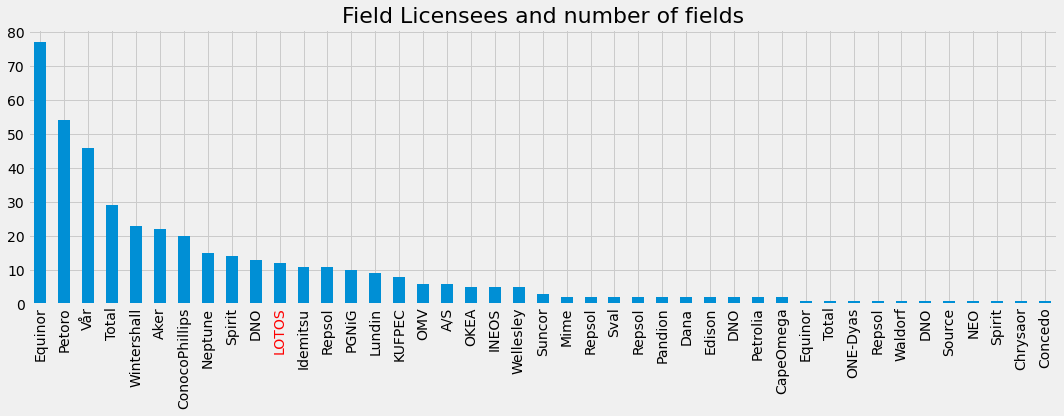

In [8]:
fig, ax = plt.subplots(figsize=(15, 6), tight_layout=True)
data.plot(kind='bar')
ax.xaxis.set_ticklabels(labelf)
plt.xticks(rotation=90); plt.title('Field Licensees and number of fields', fontsize=22)
plt.gca().get_xticklabels()[select-1].set_color('red')
plt.savefig('./figures/Field_licensees.png')
plt.show()

In [9]:
company_licences = licensees[licensees['cmpLongName']==company]
company_licences = company_licences.loc[company_licences.groupby('fldName').fldLicenseeFrom.idxmax(),:]

## Print the number of Fields that the selected company has an interest in

In [10]:
print(f"Number of Fields for {company}: {len(company_licences)}")

Number of Fields for LOTOS Exploration and Production Norge AS: 12


In [11]:
company_fields = list(company_licences['fldName'])
company_fields

['ATLA',
 'FRØY',
 'GUNGNE',
 'HEIMDAL',
 'LILLE-FRIGG',
 'SKIRNE',
 'SLEIPNER VEST',
 'SLEIPNER ØST',
 'UTGARD',
 'VALE',
 'YME',
 'ØST FRIGG']

In [12]:
inplacevols = load(fields[6])

# In place volumes for specified Company

In [13]:
company_inplacevols = calculate(company_fields, inplacevols)
company_inplacevols.to_csv('./export/in_place_volumes.csv', index=False);

In [14]:
company_inplacevols

,fldName,fldInplaceOil,fldInplaceAssLiquid,fldInplaceAssGas,fldInplaceFreeGas,fldDateOffResEstDisplay,fldNpdidField
3,ATLA,0.0,0.0,0.0,1.88,2019-12-31,21106284.0
26,FRØY,27.0,0.0,6.0,0.00,2019-12-31,43597.0
37,GUNGNE,0.0,15.0,0.0,19.62,2019-12-31,43464.0
41,HEIMDAL,11.0,0.0,0.0,61.40,2019-12-31,43590.0
54,LILLE-FRIGG,4.0,0.0,7.0,0.00,2019-12-31,43583.0
78,SKIRNE,5.0,0.0,0.0,14.72,2019-12-31,2138816.0
81,SLEIPNER VEST,0.0,79.0,0.0,185.11,2019-12-31,43457.0
82,SLEIPNER ØST,0.0,77.0,0.0,90.70,2019-12-31,43478.0
103,UTGARD,0.0,6.0,0.0,4.97,2019-12-31,28975098.0
104,VALE,0.0,10.0,0.0,8.30,2019-12-31,1578893.0


In [15]:
# Field reserves
reserves = load(fields[5])
# Field reserves at Company share ('fldCompanyShare')
reserves_comp = load(fields[8]) 

# Reserves for each Field the specified company has an interest in

In [16]:
reserves_comp = reserves_comp[reserves_comp['cmpLongName']==company]
reserves_comp.drop(['cmpLongName', 'cmpDateOffResEstDisplay', 'fldNpdidField', 'cmpNpdidCompany'], axis=1, inplace=True)
reserves_comp.loc['Total'] = reserves_comp.sum(numeric_only=True, axis=0)
reserves_comp.to_csv('./export/reserves_company.csv', index=False)
reserves_comp

,fldName,cmpRemainingOil,cmpRemainingGas,cmpRemainingNGL,cmpRemainingCondensate,cmpRemainingOE,cmpShare
165,ATLA,0.00,0.00,0.00,0.0,0.00,20.000
166,FRØY,0.00,0.00,0.00,0.0,0.00,9.740
167,GUNGNE,0.02,0.07,0.01,0.0,0.10,15.000
168,HEIMDAL,0.00,0.00,0.00,0.0,0.00,5.000
169,LILLE-FRIGG,0.00,0.00,0.00,0.0,0.00,20.000
170,SKIRNE,0.02,0.10,0.00,0.0,0.12,30.000
171,SLEIPNER VEST,0.24,1.21,0.09,0.0,1.63,15.000
172,SLEIPNER ØST,0.01,0.04,0.00,0.0,0.06,15.000
173,UTGARD,0.25,0.43,0.08,0.0,0.84,17.360
174,VALE,0.09,0.13,0.00,0.0,0.22,25.757


## Display total reserves for each field - not company share.

In [17]:
company_reserves = calculate(company_fields, reserves)
company_reserves.to_csv('./export/reserves_all.csv', index=False)
company_reserves

,fldName,fldRecoverableOil,fldRecoverableGas,fldRecoverableNGL,fldRecoverableCondensate,fldRecoverableOE,fldRemainingOil,fldRemainingGas,fldRemainingNGL,fldRemainingCondensate,fldRemainingOE,fldDateOffResEstDisplay,fldNpdidField
3,ATLA,0.40,1.40,0.00,0.00,1.80,0.00,0.00,0.00,0.0,0.00,2019-12-31,21106284.0
26,FRØY,5.55,1.61,0.00,0.11,7.27,0.00,0.00,0.00,0.0,0.00,2019-12-31,43597.0
37,GUNGNE,0.33,15.77,2.19,4.47,24.73,0.10,0.44,0.05,0.0,0.64,2019-12-31,43464.0
41,HEIMDAL,6.69,46.21,0.00,0.00,52.90,0.00,0.01,0.00,0.0,0.01,2019-12-31,43590.0
54,LILLE-FRIGG,1.33,2.19,0.00,0.02,3.54,0.00,0.00,0.00,0.0,0.00,2019-12-31,43583.0
78,SKIRNE,2.42,10.68,0.00,0.00,13.10,0.07,0.34,0.00,0.0,0.41,2019-12-31,2138816.0
81,SLEIPNER VEST,5.72,146.65,10.58,29.74,202.21,1.58,8.08,0.63,0.0,10.86,2019-12-31,43457.0
82,SLEIPNER ØST,0.37,68.52,13.41,26.62,120.99,0.06,0.27,0.03,0.0,0.39,2019-12-31,43478.0
103,UTGARD,1.06,1.68,0.34,0.00,3.39,0.89,1.54,0.30,0.0,3.00,2019-12-31,28975098.0
104,VALE,2.62,2.64,0.00,0.00,5.26,0.34,0.51,0.00,0.0,0.85,2019-12-31,1578893.0


In [18]:
# production_monthly_by_field
production_mthly_field = load(fields[10])

In [19]:
production_mthly_field.head()

,prfInformationCarrier,prfYear,prfMonth,prfPrdOilNetMillSm3,prfPrdGasNetBillSm3,prfPrdNGLNetMillSm3,prfPrdCondensateNetMillSm3,prfPrdOeNetMillSm3,prfPrdProducedWaterInFieldMillSm3,prfNpdidInformationCarrier
0,24/9-12 S (Frosk),2019-01-01,8,0.01705,0.00068,0.0,0.0,0.01772,0.00061,31140456
1,24/9-12 S (Frosk),2019-01-01,9,0.05557,0.00323,0.0,0.0,0.05880,0.00000,31140456
2,24/9-12 S (Frosk),2019-01-01,10,0.04403,0.00258,0.0,0.0,0.04661,0.00000,31140456
3,24/9-12 S (Frosk),2019-01-01,11,0.05350,0.00299,0.0,0.0,0.05648,0.00000,31140456
4,24/9-12 S (Frosk),2019-01-01,12,0.05825,0.00297,0.0,0.0,0.06123,0.00009,31140456


In [20]:
production_monthly = pd.DataFrame()
for field in company_fields:
    production_monthly = production_monthly.append(production_mthly_field[production_mthly_field.prfInformationCarrier==field])
    
production_monthly

,prfInformationCarrier,prfYear,prfMonth,prfPrdOilNetMillSm3,prfPrdGasNetBillSm3,prfPrdNGLNetMillSm3,prfPrdCondensateNetMillSm3,prfPrdOeNetMillSm3,prfPrdProducedWaterInFieldMillSm3,prfNpdidInformationCarrier
596,ATLA,2012-01-01,9,0.00000,0.00000,0.0,0.00000,0.00000,0.0,21106284
597,ATLA,2012-01-01,10,0.01300,0.01909,0.0,0.00000,0.03209,0.0,21106284
598,ATLA,2012-01-01,11,0.01594,0.02737,0.0,0.00000,0.04331,0.0,21106284
599,ATLA,2012-01-01,12,0.00947,0.00000,0.0,0.00000,0.00947,0.0,21106284
600,ATLA,2013-01-01,1,0.00649,0.00000,0.0,0.00000,0.00649,0.0,21106284
...,...,...,...,...,...,...,...,...,...,...
21460,ØST FRIGG,1997-01-01,9,0.00000,0.00618,0.0,0.00001,0.00619,0.0,43576
21461,ØST FRIGG,1997-01-01,10,0.00000,0.00516,0.0,0.00000,0.00516,0.0,43576
21462,ØST FRIGG,1997-01-01,11,0.00000,0.00443,0.0,0.00000,0.00443,0.0,43576
21463,ØST FRIGG,1997-01-01,12,0.00000,0.00449,0.0,0.00000,0.00449,0.0,43576


In [21]:
production_mthly_field.prfInformationCarrier.unique()

array(['24/9-12 S (Frosk)', '33/9-6 DELTA', '7220/11-1 (Alta)',
       'ALBUSKJELL', 'ALVE', 'ALVHEIM', 'ATLA', 'BALDER', 'BLANE',
       'BRAGE', 'BRYNHILD', 'BYRDING', 'BØYLA', 'COD', 'DRAUGEN', 'EDDA',
       'EDVARD GRIEG', 'EKOFISK', 'ELDFISK', 'EMBLA', 'ENOCH', 'FLYNDRE',
       'FRAM', 'FRAM H-NORD', 'FRIGG', 'FRØY', 'GAUPE', 'GIMLE',
       'GINA KROG', 'GJØA', 'GLITNE', 'GOLIAT', 'GRANE', 'GUDRUN',
       'GULLFAKS', 'GULLFAKS SØR', 'GUNGNE', 'GYDA', 'HEIDRUN', 'HEIMDAL',
       'HOD', 'HULDRA', 'HYME', 'ISLAY', 'IVAR AASEN', 'JETTE',
       'JOHAN SVERDRUP', 'JOTUN', 'KNARR', 'KRISTIN', 'KVITEBJØRN',
       'LILLE-FRIGG', 'MARIA', 'MARULK', 'MIKKEL', 'MIME', 'MORVIN',
       'MURCHISON', 'NJORD', 'NORDØST FRIGG', 'NORNE', 'ODA', 'ODIN',
       'ORMEN LANGE', 'OSEBERG', 'OSEBERG SØR', 'OSEBERG ØST', 'OSELVAR',
       'REV', 'RINGHORNE ØST', 'SIGYN', 'SINDRE', 'SKARV', 'SKIRNE',
       'SKOGUL', 'SKULD', 'SLEIPNER VEST', 'SLEIPNER ØST', 'SNORRE',
       'SNØHVIT', 'STATFJORD', 

<AxesSubplot:xlabel='prfYear'>

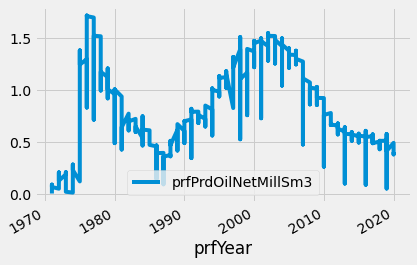

In [22]:
production_mthly_field[production_mthly_field.prfInformationCarrier=='EKOFISK'].plot(x='prfYear', y='prfPrdOilNetMillSm3')

# Overview

In [23]:
overview = load(fields[0])

## Breakdown of all fields on the NCS

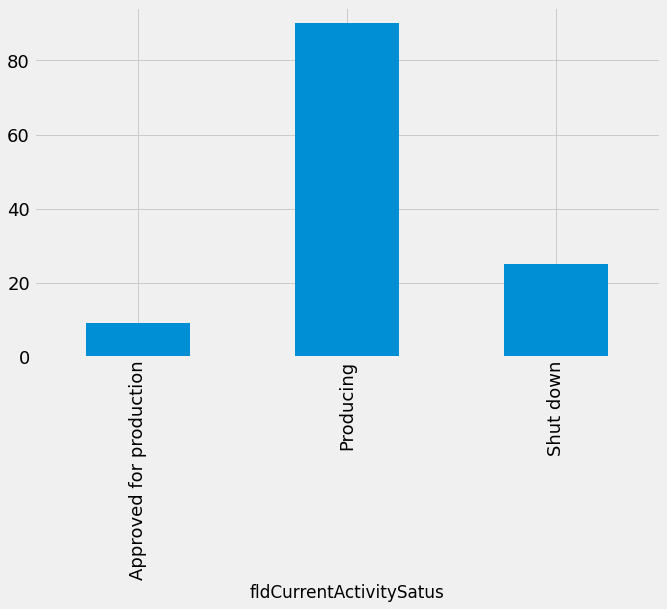

In [24]:
overview.groupby('fldCurrentActivitySatus').size().plot(kind='bar', figsize=(10,6), fontsize=18)
plt.savefig('./figures/All_Fields.png'); plt.show()

In [25]:
producing_fields = overview[overview['fldCurrentActivitySatus']=='Producing']['cmpLongName'].value_counts()
producing_approved_fields = overview[overview['fldCurrentActivitySatus'].isin(['Approved for production'])]['cmpLongName'].value_counts()
shutdown_fields = overview[overview['fldCurrentActivitySatus']=="Shut down"]['cmpLongName'].value_counts()

print(f"Number of fields: {overview.shape[0]}")
print(f"Number of producing fields: {producing_fields.sum()}")
print(f"Number of producing and approved fields: {producing_approved_fields.sum()}")
print(f"Number of shut down fields: {shutdown_fields.sum()}") # doesn't include 3 NaN entries

Number of fields: 124
Number of producing fields: 90
Number of producing and approved fields: 9
Number of shut down fields: 22


## Status of Fields by Area

fldCurrentActivitySatus  Approved for production  Producing  Shut down
fldMainArea                                                           
Barents Sea                                  1.0        2.0        NaN
North Sea                                    6.0       67.0       24.0
Norwegian Sea                                2.0       21.0        1.0
Column Total                                 9.0       90.0       25.0


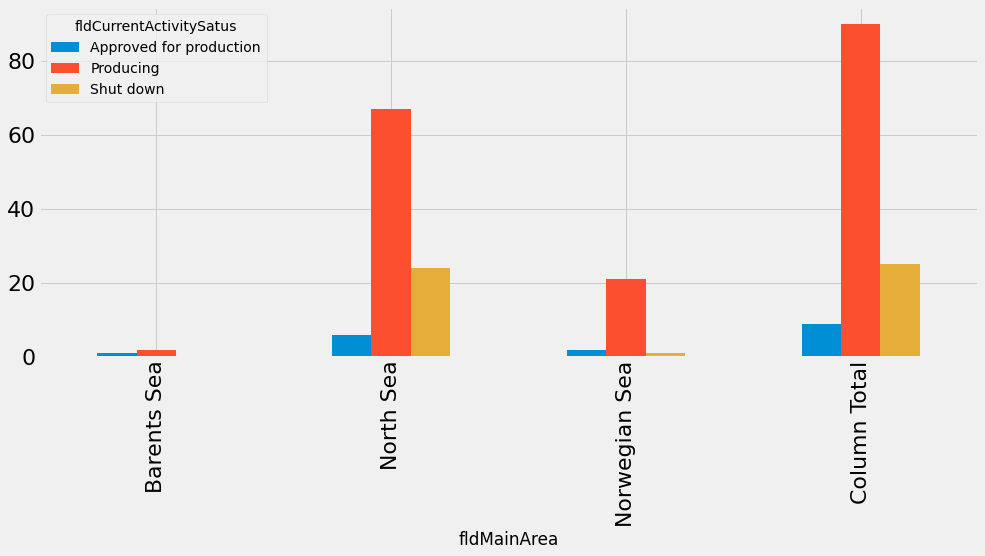

In [26]:
data = overview.groupby(['fldMainArea', 'fldCurrentActivitySatus']).size().unstack()
data.loc['Column Total'] = data.sum(numeric_only=True, axis=0)
print(data)
data.plot(kind='bar', figsize=(15,6), fontsize=22)
plt.savefig('./figures/Fields by Area.png'); plt.show()

# Yearly Investment: Total

In [27]:
#'investments_yearly_by_field' : 'https://factpages.npd.no/ReportServer_npdpublic?/FactPages/TableView/field_investment_yearly&rs:Command=Render&rc:Toolbar=false&rc:Parameters=f&rs:Format=CSV&Top100=false&IpAddress=not_used&CultureCode=en'

In [28]:
investments_y_field = load(fields[9])
investments_y_field.drop('prfNpdidInformationCarrier', axis=1, inplace=True)

In [29]:
investments_y_field.head()

,prfInformationCarrier,prfYear,prfInvestmentsMillNOK
0,ALBUSKJELL,1974-01-01,116
1,ALBUSKJELL,1975-01-01,319
2,ALBUSKJELL,1976-01-01,879
3,ALBUSKJELL,1977-01-01,398
4,ALBUSKJELL,1978-01-01,235


<AxesSubplot:xlabel='prfYear'>

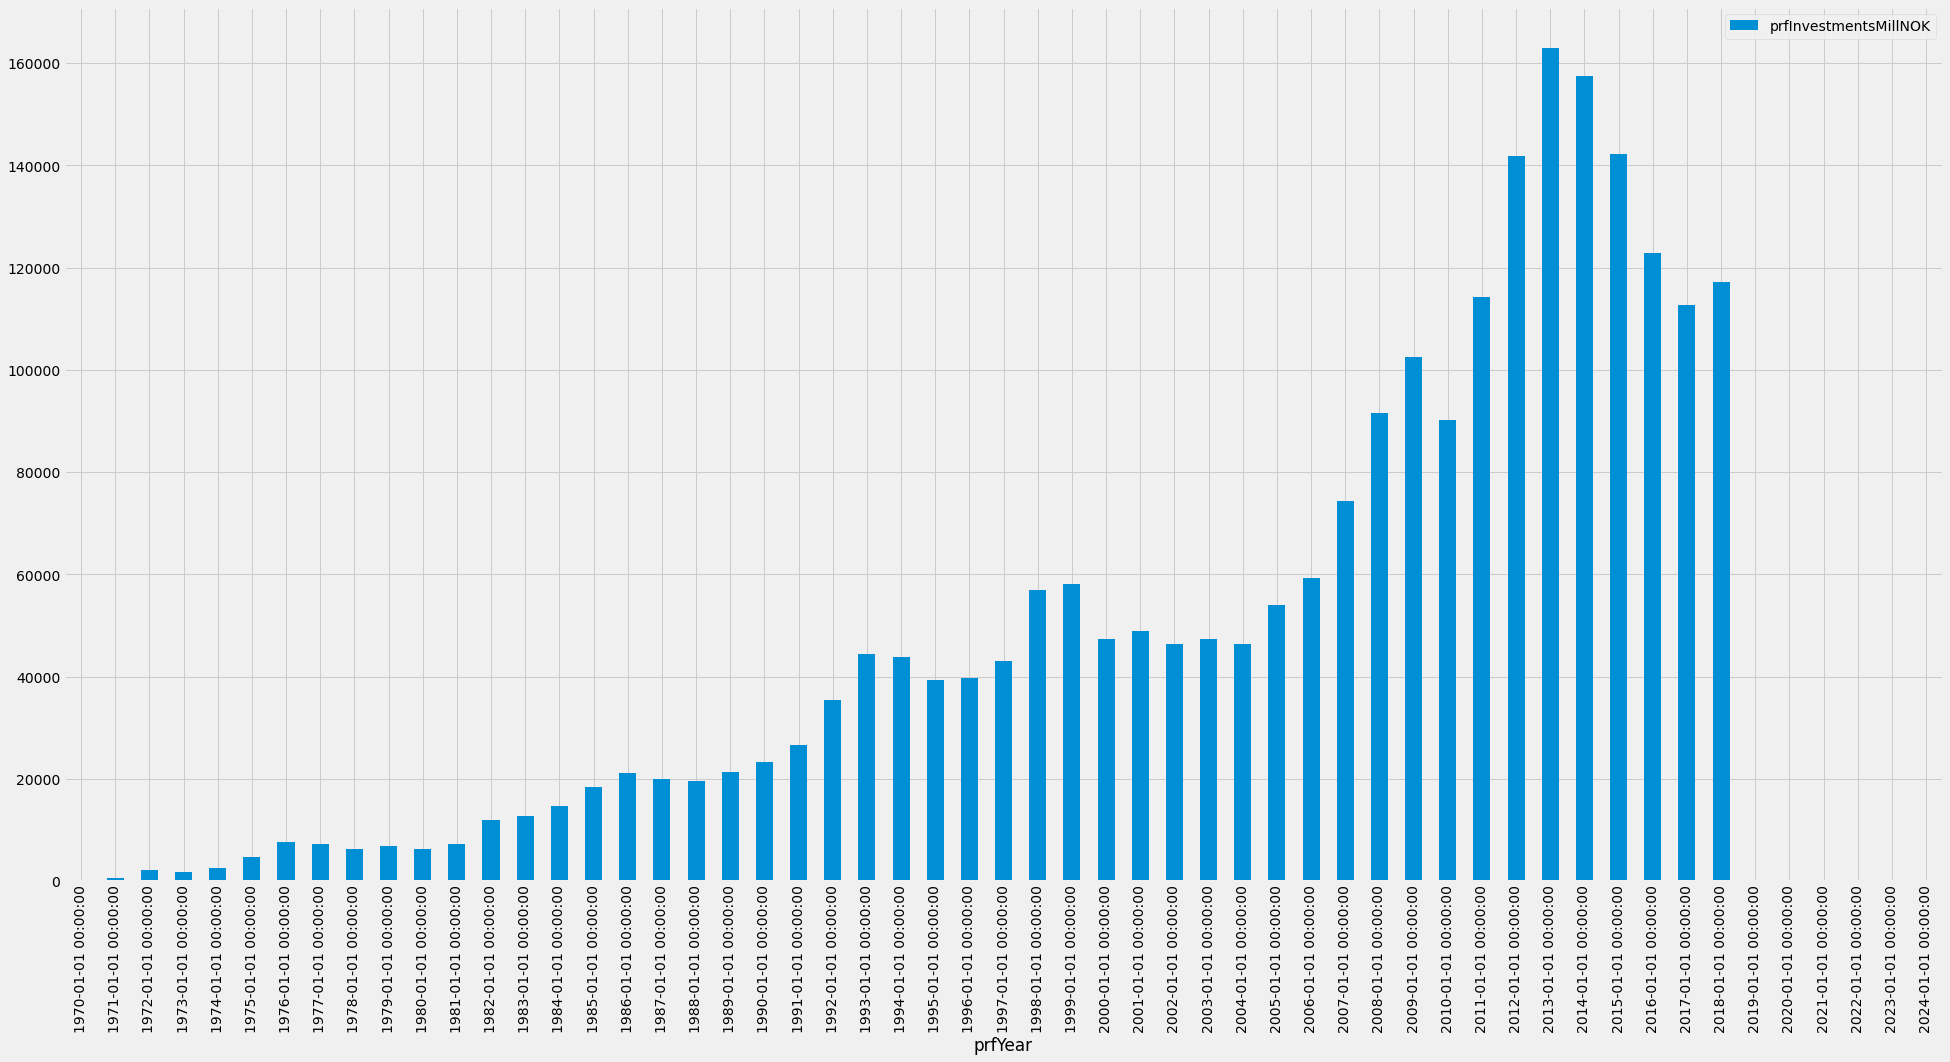

In [30]:
investments_y_field.groupby('prfYear').sum().plot(kind='bar', figsize=(30,15))

In [31]:
investments_y_field.groupby('prfInformationCarrier').sum().sort_values(by='prfInvestmentsMillNOK', ascending=False)

,prfInvestmentsMillNOK
prfInformationCarrier,
TROLL,203907
EKOFISK,149435
GULLFAKS,98456
OSEBERG,98118
ÅSGARD,96184
SNORRE,91327
VALHALL,80059
STATFJORD,77830
ELDFISK,72149


# Status

In [32]:
status = load(fields[1])

In [33]:
# status.head()

In [34]:
status.dropna(inplace=True)
status = status.loc[status.groupby('fldName').fldStatusToDate.idxmax(),:]

In [35]:
status['fldStatus'].value_counts()
#  the headings and values look transposed

Approved for production    91
Producing                  24
Shut down                   1
Name: fldStatus, dtype: int64

In [36]:
status['fldName'].nunique()

116

# Operators

In [37]:
operators = load(fields[2])

In [38]:
print(f" Number of Operators: {operators['cmpLongName'].nunique()}")
print(f" Number of Fields: {operators['fldName'].nunique()}")

 Number of Operators: 78
 Number of Fields: 124


In [39]:
# Current Operators don't have a date in the 'fldOperatorTo' field
operators[operators['fldOperatorTo'].isnull()]['cmpLongName'].value_counts() # 121 - doesn't include NaN

Equinor Energy AS                   59
Aker BP ASA                         19
ConocoPhillips Skandinavia AS        9
Wintershall Dea Norge AS             5
Vår Energi AS                        5
Repsol Norge AS                      4
A/S Norske Shell                     3
Lundin Energy Norway AS              3
Neptune Energy Norge AS              3
DNO Norge AS                         2
Total E&P Norge AS                   2
Spirit Energy Norway AS              2
OKEA ASA                             1
Repsol Sinopec North Sea Limited     1
Chrysaor Norge AS                    1
Petrogas NEO UK Ltd                  1
Total E&P UK Ltd                     1
Name: cmpLongName, dtype: int64

# Description

In [40]:
description = load(fields[7])

In [41]:
description.head()

,fldName,fldDescriptionHeading,fldDescriptionText,fldNpdidField,fldDescriptionDateUpdated
0,ALBUSKJELL,Development,Albuskjell is a field in the southern part of ...,43437,2020-02-08
1,ALBUSKJELL,Reservoir,Albuskjell produced gas and condensate from Ma...,43437,2018-03-16
2,ALBUSKJELL,Recovery,The field was produced by pressure depletion.,43437,2017-04-11
3,ALBUSKJELL,Transport,The well stream was transported via pipeline t...,43437,2018-03-16
4,ALBUSKJELL,Status,The field was shut down in 1998 and the platfo...,43437,2020-02-08
